# DL Code Demo: Transformers for NLP Tasks
### Team Members
#### 1. Rahul Reddy Talatala (UBIT: rtalatal)
#### 2. Revanth Siva Sai Ram Balineni (UBIT: rbalinen)

# Text Summarisation using BART

#### 1. Importing libraries and dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install evaluate datasets rouge_score accelerate torchinfo -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sbn
import math
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import pipeline
from transformers import DataCollatorForSeq2Seq
import evaluate
from datasets import Dataset, load_metric
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from wordcloud import WordCloud
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from torchinfo import summary
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import warnings
warnings.filterwarnings("ignore")

#### 2. Importing the dataset

In [5]:
#importing the training, validation and test dataset
trainDF = pd.read_csv("/content/drive/MyDrive/DL Code Demo/train.csv")
valDF = pd.read_csv("/content/drive/MyDrive/DL Code Demo/validation.csv")
testDF = pd.read_csv("/content/drive/MyDrive/DL Code Demo/test.csv")

In [6]:
print("Dimensions of Training Dataset: ", trainDF.shape)
print("Dimensions of Validation Dataset: ", valDF.shape)
print("Dimensions of Test Dataset: ", testDF.shape)

Dimensions of Training Dataset:  (12460, 4)
Dimensions of Validation Dataset:  (500, 4)
Dimensions of Test Dataset:  (1500, 4)


In [7]:
#displaying the first 5 rows of the dataframe
trainDF.head()

id                                           dialogue  \
0  train_0  #Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...   
1  train_1  #Person1#: Hello Mrs. Parker, how have you bee...   
2  train_2  #Person1#: Excuse me, did you see a set of key...   
3  train_3  #Person1#: Why didn't you tell me you had a gi...   
4  train_4  #Person1#: Watsup, ladies! Y'll looking'fine t...   

                                             summary              topic  
0  Mr. Smith's getting a check-up, and Doctor Haw...     get a check-up  
1  Mrs Parker takes Ricky for his vaccines. Dr. P...           vaccines  
2  #Person1#'s looking for a set of keys and asks...          find keys  
3  #Person1#'s angry because #Person2# didn't tel...  have a girlfriend  
4  Malik invites Nikki to dance. Nikki agrees if ...              dance

In [8]:
#printing a sample dialogue
print("Dialogue:\n", trainDF.iloc[0]["dialogue"])
print("\nSummary:\n", trainDF.iloc[0]["summary"])
print("\nTopic:\n", trainDF.iloc[0]["topic"])

Dialogue:
 #Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?
#Person2#: I found it would be a good idea to get a check-up.
#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.
#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?
#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.
#Person2#: Ok.
#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?
#Person2#: Yes.
#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.
#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.
#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.
#Person2#: Ok, thanks doctor.

Summary:
 Mr. Smith's getting a check-up, and Doctor Haw

#### 3. Statistics of the Dataset

In [9]:
#displaying information about the dataset
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12460 entries, 0 to 12459
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        12460 non-null  object
 1   dialogue  12460 non-null  object
 2   summary   12460 non-null  object
 3   topic     12460 non-null  object
dtypes: object(4)
memory usage: 389.5+ KB


In [10]:
#checking if there are any missing values in training
trainDF.isna().sum()

id          0
dialogue    0
summary     0
topic       0
dtype: int64

In [11]:
#checking if there are any duplicated values in training
trainDF.duplicated().sum()

0

In [12]:
#checking if there are any missing values in validation
valDF.isna().sum()

id          0
dialogue    0
summary     0
topic       0
dtype: int64

In [13]:
#checking if there are any duplicated values in validation
valDF.duplicated().sum()

0

In [14]:
#checking if there are any missing values in test
testDF.isna().sum()

id          0
dialogue    0
summary     0
topic       0
dtype: int64

In [15]:
#checking if there are any duplicated values in test
testDF.duplicated().sum()

0

In [16]:
# #displaying the no of topics in the dataset
print("Topic distribution of Training Dataset:")
print(trainDF['topic'].value_counts())

Topic distribution of Training Dataset:
topic
shopping               174
job interview          161
daily casual talk      125
phone call              89
order food              79
                      ... 
Overseas travelling      1
Own house                1
Seat exchange            1
Buying a watch           1
join the library         1
Name: count, Length: 7434, dtype: int64


In [17]:
#displaying statistics based on the length of the dialogue and summary
#adding a new column to the dataframe to store the length of the dialogue
trainDF['diagLength'] = trainDF['dialogue'].apply(len)
#adding a new column to the dataframe to store the length of the summary
trainDF['summaryLength'] = trainDF['summary'].apply(len)
print("Statistics for dialogue length (Training Dataset):")
print(trainDF['diagLength'].describe())
print("\nStatistics for summary length (Training Dataset):")
print(trainDF['summaryLength'].describe())

Statistics for dialogue length (Training Dataset):
count    12460.000000
mean       738.281300
std        396.544752
min        190.000000
25%        485.000000
50%        653.000000
75%        916.000000
max       5178.000000
Name: diagLength, dtype: float64

Statistics for summary length (Training Dataset):
count    12460.000000
mean       140.733547
std         65.133972
min         31.000000
25%         95.000000
50%        129.000000
75%        173.000000
max       1039.000000
Name: summaryLength, dtype: float64


In [18]:
#displaying statistics based on the length of the dialogue and summary
#adding a new column to the dataframe to store the length of the dialogue
valDF['diagLength'] = valDF['dialogue'].apply(len)
#adding a new column to the dataframe to store the length of the summary
valDF['summaryLength'] = valDF['summary'].apply(len)
print("Statistics for dialogue length (Validation Dataset):")
print(valDF['diagLength'].describe())
print("\nStatistics for summary length (Validation Dataset):")
print(valDF['summaryLength'].describe())

Statistics for dialogue length (Validation Dataset):
count     500.000000
mean      727.386000
std       366.971931
min       211.000000
25%       477.000000
50%       642.500000
75%       912.500000
max      2563.000000
Name: diagLength, dtype: float64

Statistics for summary length (Validation Dataset):
count    500.000000
mean     129.952000
std       59.074438
min       33.000000
25%       86.750000
50%      117.000000
75%      158.500000
max      398.000000
Name: summaryLength, dtype: float64


In [19]:
#displaying statistics based on the length of the dialogue and summary
#adding a new column to the dataframe to store the length of the dialogue
testDF['diagLength'] = testDF['dialogue'].apply(len)
#adding a new column to the dataframe to store the length of the summary
testDF['summaryLength'] = testDF['summary'].apply(len)
print("Statistics for dialogue length (Test Dataset):")
print(testDF['diagLength'].describe())
print("\nStatistics for summary length (Test Dataset):")
print(testDF['summaryLength'].describe())

Statistics for dialogue length (Test Dataset):
count    1500.000000
mean      757.324000
std       424.975239
min       209.000000
25%       472.750000
50%       668.000000
75%       956.000000
max      4430.000000
Name: diagLength, dtype: float64

Statistics for summary length (Test Dataset):
count    1500.000000
mean      114.521333
std        50.470239
min        27.000000
25%        79.000000
50%       105.000000
75%       140.000000
max       467.000000
Name: summaryLength, dtype: float64


### From the above statistics we can infer that the average length of dialogue conversation is 738 characters and the avergae length of summary is 140 characters. This information is useful in configuring the max length of the sequence in the coming sections

#### 4. Visualisations of the dataset

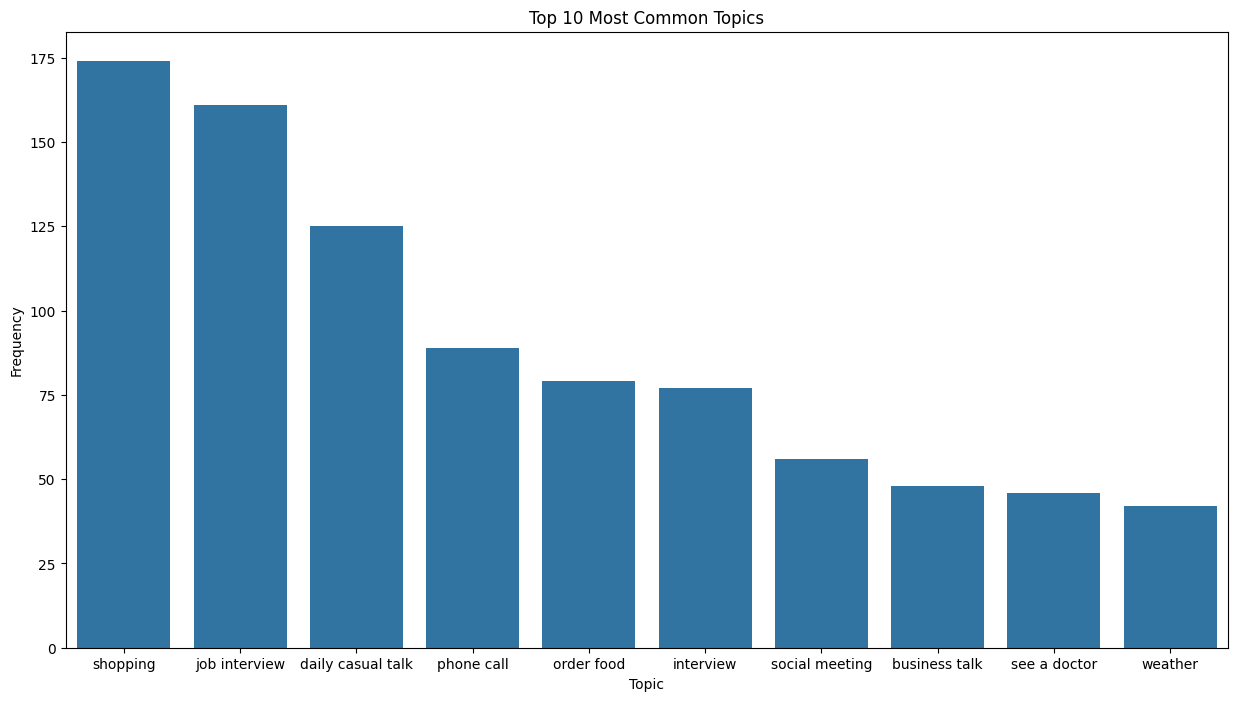

In [20]:
#fetching the frequencies of each topic
topicFreq = trainDF['topic'].value_counts()
#configuring the canvas size
plt.figure(figsize=(15, 8))
#generating a bar plot with the topic as the x-axis and their freq as y-axis
sbn.barplot(x=topicFreq.index[:10], y=topicFreq.values[:10])
#setting the labels and the title
plt.title('Top 10 Most Common Topics')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.show()


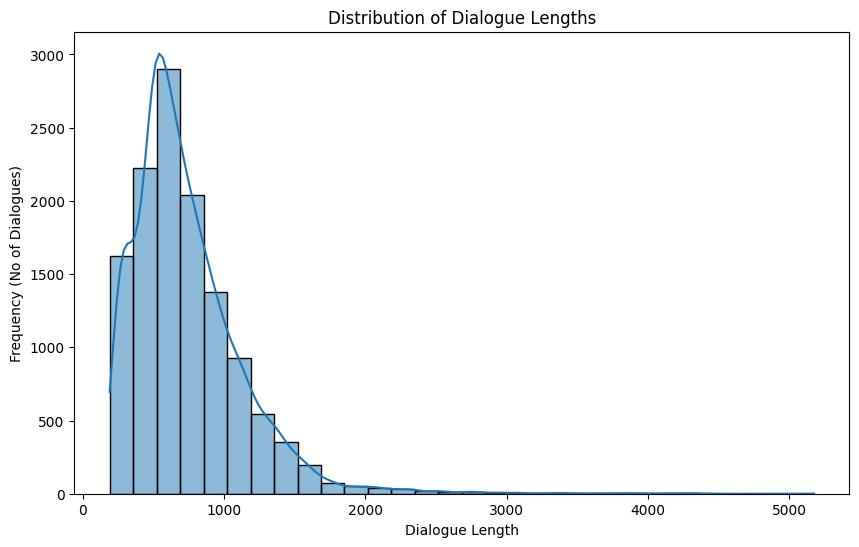

In [21]:
#plot the distribution of dialogue lengths
#configuring the canvas size
plt.figure(figsize=(10, 6))
#generating a histogram for the 'diagLength' column
sbn.histplot(data=trainDF, x='diagLength', bins=30, kde=True)
#setting the title and labels
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Dialogue Length')
plt.ylabel('Frequency (No of Dialogues)')
plt.show()

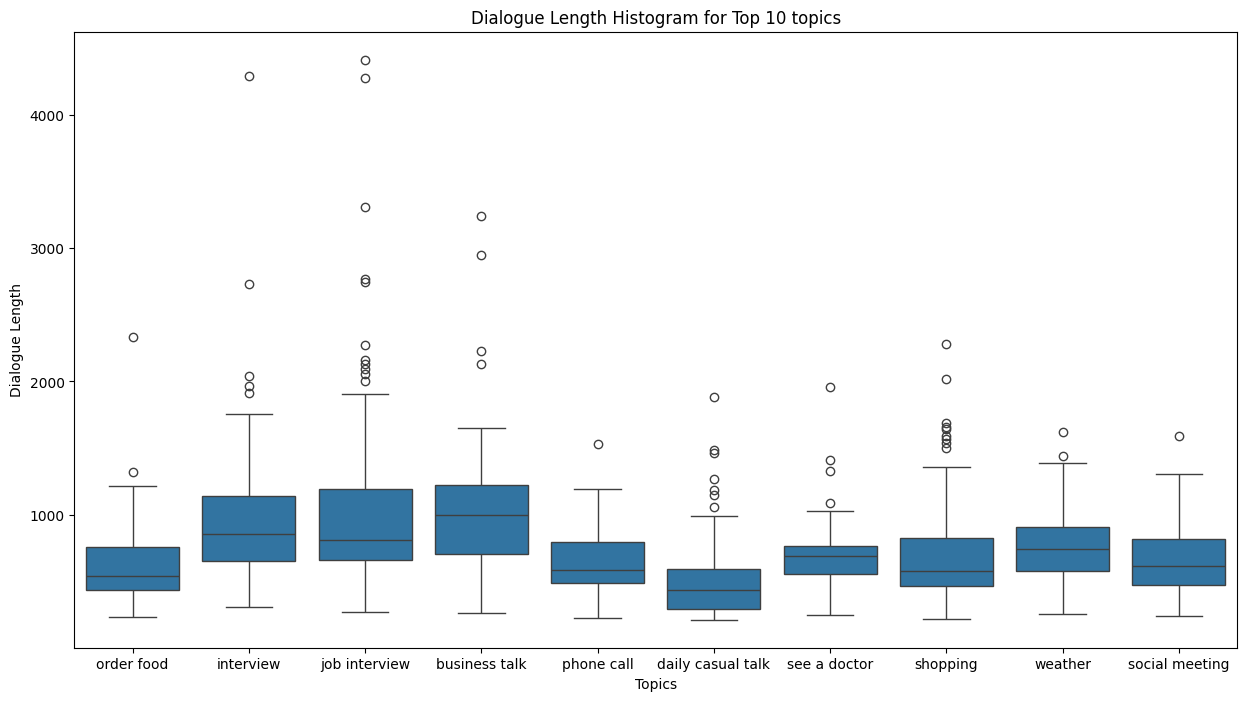

In [22]:
#plotting a box plot of dialogue length distribution
#setting the figure size
plt.figure(figsize=(15, 8))
filterTrainDF = trainDF[trainDF['topic'].isin(topicFreq.index[:10])]
#creating a boxplot for the content length wrt class in the the dataframe
sbn.boxplot(x='topic', y='diagLength', data=filterTrainDF)
#setting the title and labels
plt.title('Dialogue Length Histogram for Top 10 topics')
plt.xlabel('Topics')
plt.ylabel('Dialogue Length')
#displaying the plot
plt.show()

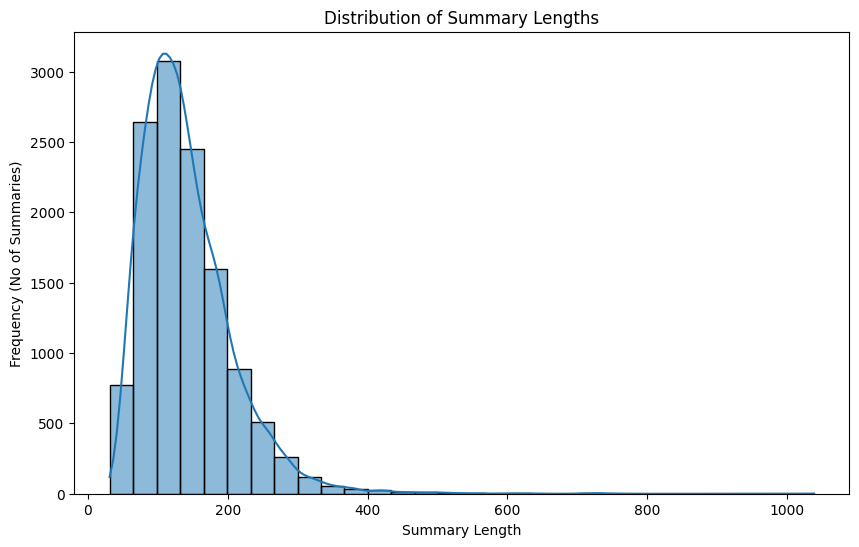

In [23]:
#plot the distribution of summary lengths
#configuring the canvas size
plt.figure(figsize=(10, 6))
#generating a histogram for the 'summaryLength' column
sbn.histplot(data=trainDF, x='summaryLength', bins=30, kde=True)
#setting the title and labels
plt.title('Distribution of Summary Lengths')
plt.xlabel('Summary Length')
plt.ylabel('Frequency (No of Summaries)')
plt.show()

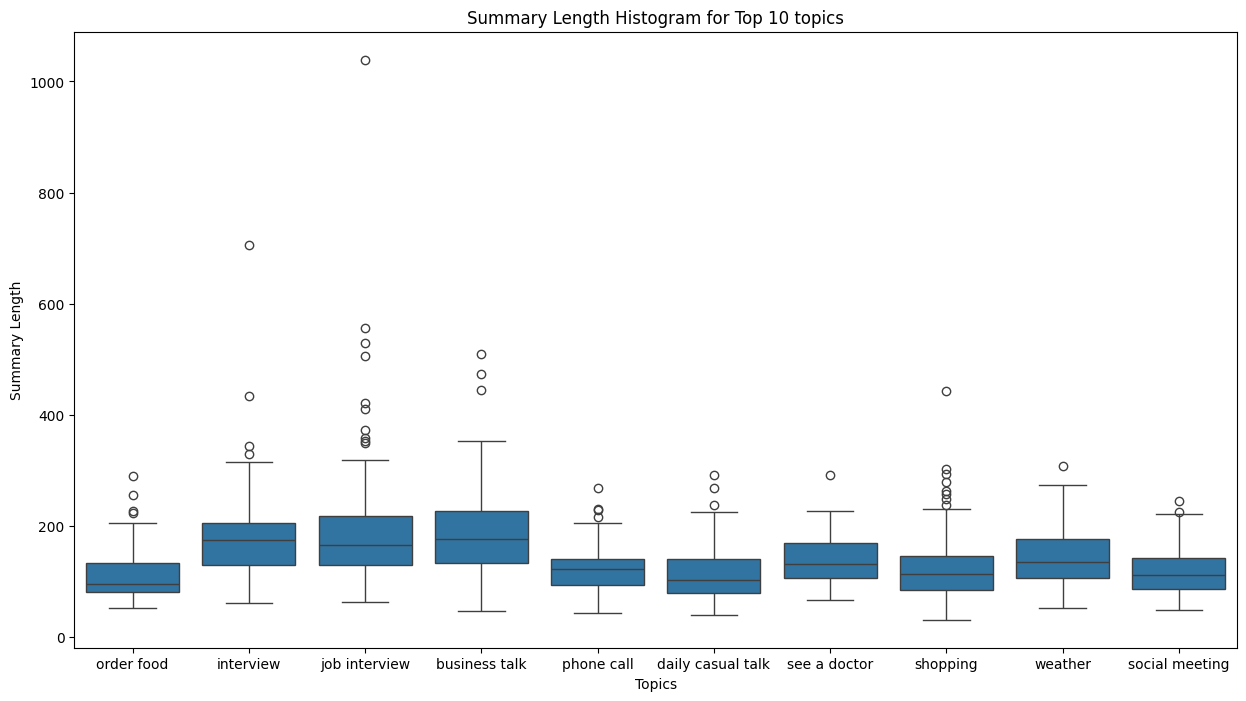

In [24]:
#plotting a box plot of summary length distribution
#setting the figure size
plt.figure(figsize=(15, 8))
#creating a boxplot for the content length wrt class in the the dataframe
sbn.boxplot(x='topic', y='summaryLength', data=filterTrainDF)
#setting the title and labels
plt.title('Summary Length Histogram for Top 10 topics')
plt.xlabel('Topics')
plt.ylabel('Summary Length')
#displaying the plot
plt.show()

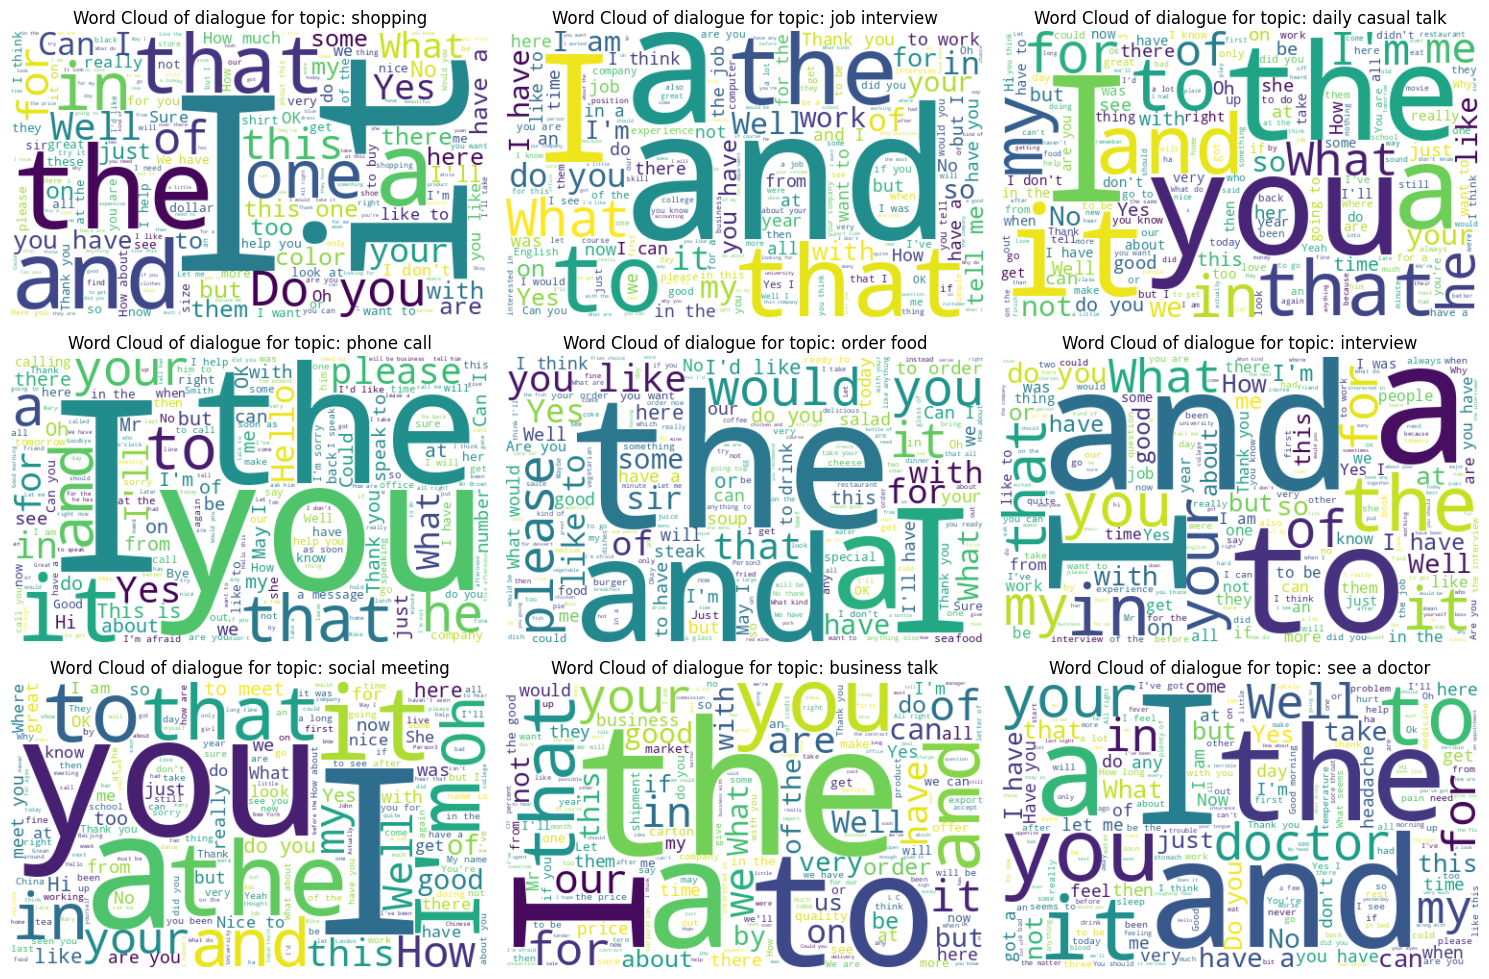

In [25]:
#displaying the wordcloud for dialogue column for the top 10 topics
#initialising the no of class and no of rows for displaying the word cloud
noOfClasses = 10
noOfRows = (noOfClasses + 1) // 3
top10 = list(topicFreq.index[:10])
#setting the figure size
plt.figure(figsize=(15, 10))
#iterate over each class to create a word cloud
for i in range(1, noOfClasses):
    #concatenating all the contents of 'classLabel' into a single string
    topicContents = ' '.join(filterTrainDF[filterTrainDF['topic'] == top10[i-1]]['dialogue'])
    #generate the word cloud for the above string
    topicWC = WordCloud(stopwords=["Person1","Person2"],width=500, height=300, background_color='white').generate(topicContents)
    #creating a subplot for the current class
    plt.subplot(noOfRows, 3, i)
    #creating an image from the word cloud
    plt.imshow(topicWC, interpolation='bilinear')
    plt.axis('off')
    #setting the title
    plt.title(f'Word Cloud of dialogue for topic: {top10[i-1]}')

#adjusting the layout to avoid overlap
plt.tight_layout()
#display the word cloud
plt.show()

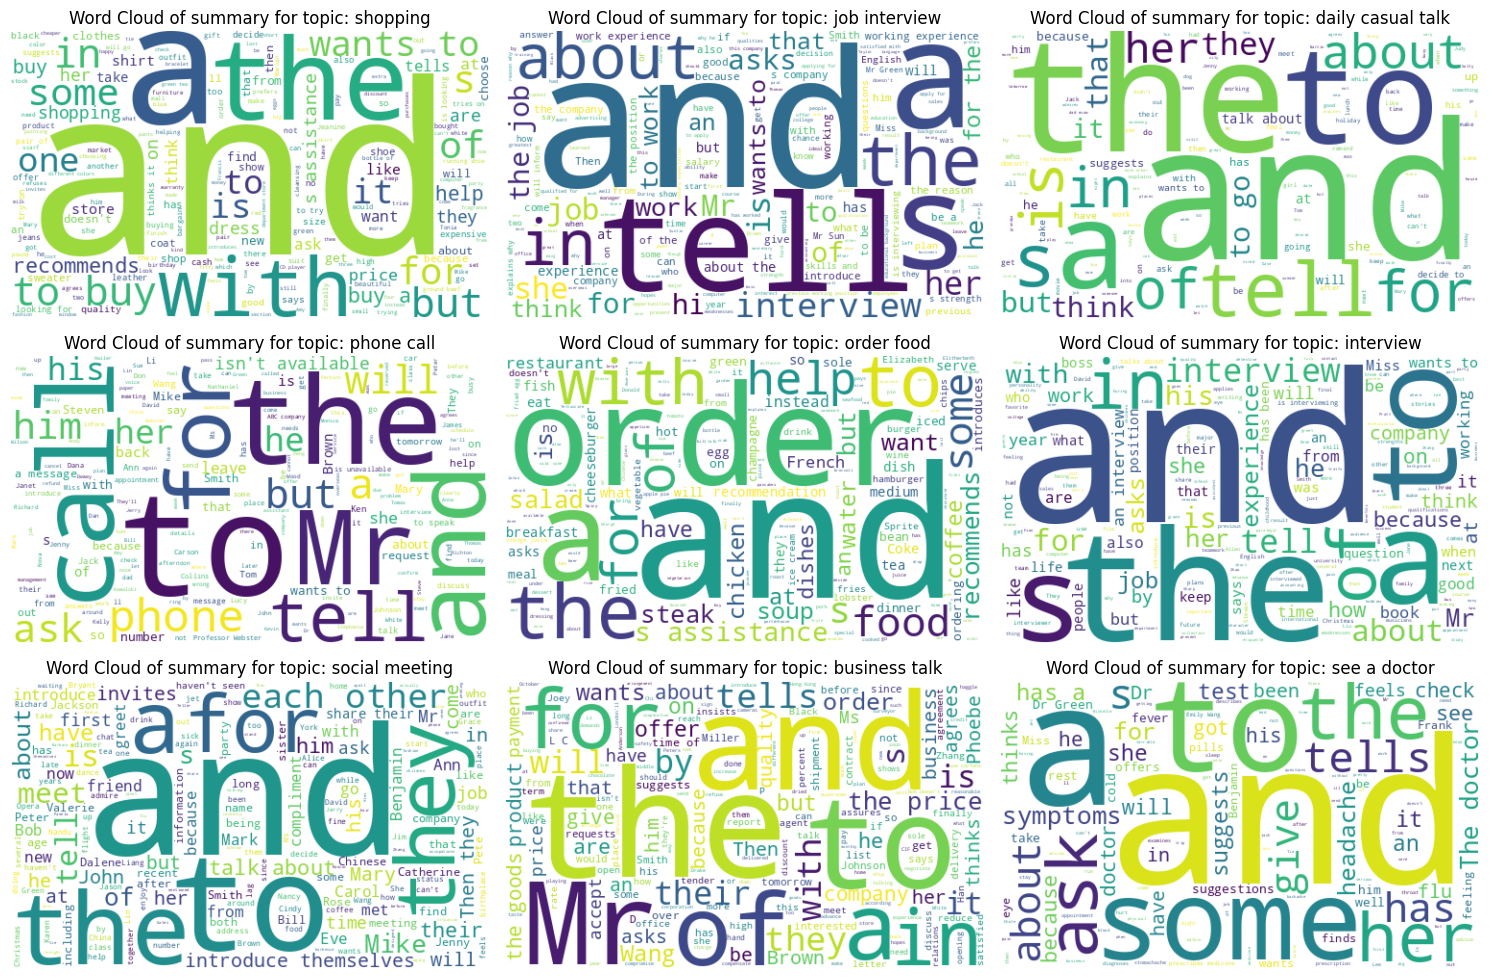

In [26]:
#displaying the wordcloud for summary column for the top 10 topics
#initialising the no of class and no of rows for displaying the word cloud
noOfClasses = 10
noOfRows = (noOfClasses + 1) // 3
top10 = list(topicFreq.index[:10])
#setting the figure size
plt.figure(figsize=(15, 10))
#iterate over each class to create a word cloud
for i in range(1, noOfClasses):
    #concatenating all the contents of 'classLabel' into a single string
    summaryContents = ' '.join(filterTrainDF[filterTrainDF['topic'] == top10[i-1]]['summary'])
    #generate the word cloud for the above string
    summaryWC = WordCloud(stopwords=["Person1","Person2"], width=500, height=300, background_color='white').generate(summaryContents)
    #creating a subplot for the current class
    plt.subplot(noOfRows, 3, i)
    #creating an image from the word cloud
    plt.imshow(summaryWC, interpolation='bilinear')
    plt.axis('off')
    #setting the title
    plt.title(f'Word Cloud of summary for topic: {top10[i-1]}')

#adjusting the layout to avoid overlap
plt.tight_layout()
#display the word cloud
plt.show()

In [27]:
#checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device('cuda')
else:
    print("GPU is not available")
    device = torch.device('cpu')

GPU is available!


#### 5. TF-IDF Vectorisation on Dialogue and Summary columns

In [28]:
#combining the default english stop words with the extra stop words
stopWords = list(text.ENGLISH_STOP_WORDS.union(["person1", "person2"]))
#initialising the TfidfVectorizer with the combined stop words to fetch the top 15 terms in the dialogue column
tfIDF = TfidfVectorizer(max_features=15, stop_words=stopWords)
#fitting the vectorizer on the 'dialogue' column in the training data
trainTFID = tfIDF.fit_transform(trainDF['dialogue'])
#converting to a dataframe
trainTFID_DF = pd.DataFrame(trainTFID.toarray(), columns=tfIDF.get_feature_names_out())
trainTFID_DF

don     going      good      just      know      like        ll  \
0      0.000000  0.000000  0.495658  0.251422  0.514289  0.000000  0.248166   
1      0.000000  0.000000  0.000000  0.485998  0.000000  0.000000  0.479705   
2      0.421084  0.000000  0.000000  0.000000  0.452202  0.385966  0.000000   
3      0.000000  0.410546  0.000000  0.000000  0.347010  0.000000  0.000000   
4      0.284883  0.000000  0.294853  0.000000  0.000000  0.261124  0.590509   
...         ...       ...       ...       ...       ...       ...       ...   
12455  0.396751  0.000000  0.000000  0.416590  0.000000  0.727325  0.000000   
12456  0.305873  0.388620  0.316577  0.321167  0.000000  0.000000  0.317008   
12457  0.000000  0.000000  0.000000  0.000000  0.000000  0.870512  0.492147   
12458  0.000000  0.587452  0.478550  0.485488  0.000000  0.000000  0.000000   
12459  0.000000  0.000000  0.000000  0.397793  0.406848  0.000000  0.000000   

             oh    really     right     think      time        ve  want  \
0      0.000000  0.273283  0.000000  0.000000  0.000000  0.293793   0.0   
1      0.000000  0.000000  0.000000  0.497002  0.535423  0.000000   0.0   
2      0.481625  0.000000  0.000000  0.000000  0.487103  0.000000   0.0   
3      0.369588  0.000000  0.000000  0.693938  0.000000  0.000000   0.0   
4      0.000000  0.000000  0.644217  0.000000  0.000000  0.000000   0.0   
...         ...       ...       ...       ...       ...       ...   ...   
12455  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
12456  0.000000  0.000000  0.345841  0.328438  0.000000  0.375291   0.0   
12457  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
12458  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
12459  0.000000  0.000000  0.000000  0.406800  0.000000  0.000000   0.0   

            yes  
0      0.451700  
1      0.000000  
2      0.000000  
3      0.304778  
4      0.000000  
...         ...  
12455  0.374218  
12456  0.288501  
12457  0.000000  
12458  0.436109  
12459  0.714667  

[12460 rows x 15 columns]

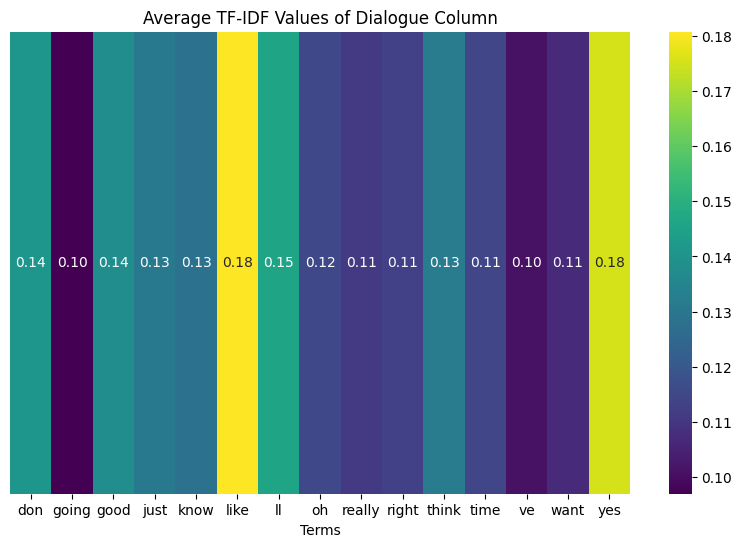

In [29]:
#computing the mean TF-IDF values for each term across all rows
meanTFIDF = trainTFID_DF.mean()
#reshaping the dataframe to create a heatmap
heatmapData = meanTFIDF.values.reshape(1, -1)
#configuring the canvas size
plt.figure(figsize=(10, 6))
#generating the heatmap
sbn.heatmap(heatmapData, cmap='viridis', annot=True, fmt=".2f", xticklabels=meanTFIDF.index, yticklabels=False)
#setting the labels and title
plt.title('Average TF-IDF Values of Dialogue Column')
plt.xlabel('Terms')
plt.show()

In [30]:
#combining the default english stop words with the extra stop words
stopWords = list(text.ENGLISH_STOP_WORDS.union(["person1", "person2"]))
#initialising the TfidfVectorizer with the combined stop words to fetch the top 15 terms in the dialogue column
tfIDF = TfidfVectorizer(max_features=15, stop_words=stopWords)
#fitting the vectorizer on the 'summary' column in the training data
trainTFID = tfIDF.fit_transform(trainDF['summary'])
#converting to a dataframe
trainTFID_DF = pd.DataFrame(trainTFID.toarray(), columns=tfIDF.get_feature_names_out())
trainTFID_DF

asks     doesn  helps   invites       job        mr  new  says  \
0      0.000000  0.000000    0.0  0.000000  0.000000  1.000000  0.0   0.0   
1      0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.0   0.0   
2      1.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.0   0.0   
3      0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.0   0.0   
4      0.000000  0.697519    0.0  0.716566  0.000000  0.000000  0.0   0.0   
...         ...       ...    ...       ...       ...       ...  ...   ...   
12455  0.000000  0.000000    0.0  0.000000  0.000000  1.000000  0.0   0.0   
12456  0.596373  0.000000    0.0  0.000000  0.000000  0.802708  0.0   0.0   
12457  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.0   0.0   
12458  0.000000  0.000000    0.0  0.000000  0.763443  0.000000  0.0   0.0   
12459  1.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.0   0.0   

       suggests  talk  tells  thinks  time  wants  work  
0      0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
1      0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
2      0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
3      0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
4      0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
...         ...   ...    ...     ...   ...    ...   ...  
12455  0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
12456  0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
12457  0.000000   0.0    0.0     0.0   0.0    0.0   0.0  
12458  0.645875   0.0    0.0     0.0   0.0    0.0   0.0  
12459  0.000000   0.0    0.0     0.0   0.0    0.0   0.0  

[12460 rows x 15 columns]

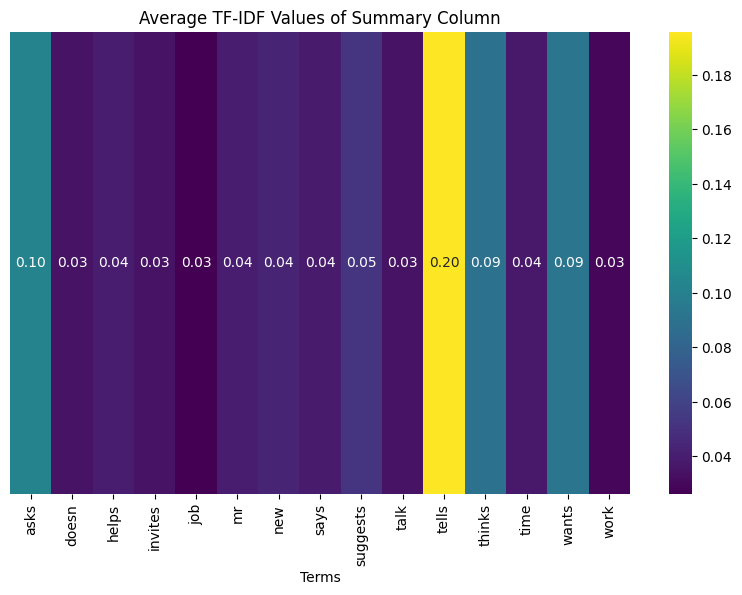

In [31]:
#computing the mean TF-IDF values for each term across all rows
meanTFIDF = trainTFID_DF.mean()
#reshaping the dataframe to create a heatmap
heatmapData = meanTFIDF.values.reshape(1, -1)
#configuring the canvas size
plt.figure(figsize=(10, 6))
#generating the heatmap
sbn.heatmap(heatmapData, cmap='viridis', annot=True, fmt=".2f", xticklabels=meanTFIDF.index, yticklabels=False)
#setting the labels and title
plt.title('Average TF-IDF Values of Summary Column')
plt.xlabel('Terms')
plt.show()

#### 6. Generating the Datasets to fit the model

In [32]:
#dropping the extra columns to create the dataset
trainDF.drop(columns=['topic', 'summaryLength', 'diagLength'], inplace=True)
valDF.drop(columns=['topic', 'summaryLength', 'diagLength'], inplace=True)
testDF.drop(columns=['topic', 'summaryLength', 'diagLength'], inplace=True)

In [33]:
#transforming dataframes into datasets with the hugging-face dataset library
trainDataset = Dataset.from_pandas(trainDF)
valDataset = Dataset.from_pandas(valDF)
testDataset = Dataset.from_pandas(testDF)

In [34]:
print("Dimensions of the Training Dataset: ", trainDataset.shape)
print("Dimensions of the Validation Dataset: ", valDataset.shape)
print("Dimensions of the Test Dataset: ", testDataset.shape)

Dimensions of the Training Dataset:  (12460, 3)
Dimensions of the Validation Dataset:  (500, 3)
Dimensions of the Test Dataset:  (1500, 3)


In [35]:
#displaying a sample row in the training dataset
trainDataset[0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

#### 7. Tokenising the Datasets

In [36]:
#this function is used to tokenize the dataset
def tokenizeDataset(dataset, tokenizer, diagLength=750, summaryLength=150):
  #tokenising the dialogues in the dataset and fetching the tensors
  #specifying the max length of the dialogues to be 750 and if a dialogue is longer than that it gets truncated
  dialogues = tokenizer(dataset["dialogue"], max_length=diagLength, truncation=True, padding="max_length", return_tensors="pt")
  #setting the tokenizer to genreate token IDs for the target sequences
  with tokenizer.as_target_tokenizer():
    #tokenising the dialogues in the dataset and fetching the tensors
    #specifying the max length of the dialogues to be 150 and if a dialogue is longer than that it gets truncated
    summaries = tokenizer(dataset["summary"], max_length=summaryLength, truncation=True, padding="max_length", return_tensors="pt")
  #assigning the tokenised summary sequences as labels for the dialogue input sequences
  dialogues["labels"] = summaries["input_ids"]
  return Dataset.from_dict(dialogues)

In [37]:
#loading the BART tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-xsum')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

In [38]:
#tokenising the all the datasets
trainTokenizedDataset = tokenizeDataset(trainDataset, tokenizer)
valTokenizedDataset = tokenizeDataset(valDataset, tokenizer)
testTokenizedDataset = tokenizeDataset(testDataset, tokenizer)

In [39]:
trainTokenizedDataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12460
})

In [40]:
#printing a sample tokenized row in the train dataset
print("Input IDs for the first row in tokenized train dataset:")
print(trainTokenizedDataset[0]['input_ids'])
print("\nAttention Mask for the first row in tokenized train dataset:")
print(trainTokenizedDataset[0]['attention_mask'])
print("\nLabels for the first row in tokenized train dataset:")
print(trainTokenizedDataset[0]['labels'])

Input IDs for the first row in tokenized train dataset:
[0, 10431, 41761, 134, 10431, 35, 12289, 6, 427, 4, 1259, 4, 38, 437, 12521, 15633, 4, 2612, 32, 47, 259, 452, 116, 50118, 10431, 41761, 176, 10431, 35, 38, 303, 24, 74, 28, 10, 205, 1114, 7, 120, 10, 1649, 12, 658, 4, 50118, 10431, 41761, 134, 10431, 35, 3216, 6, 157, 6, 47, 2220, 75, 56, 65, 13, 195, 107, 4, 370, 197, 33, 65, 358, 76, 4, 50118, 10431, 41761, 176, 10431, 35, 38, 216, 4, 38, 1955, 25, 251, 25, 89, 16, 1085, 1593, 6, 596, 213, 192, 5, 3299, 116, 50118, 10431, 41761, 134, 10431, 35, 2647, 6, 5, 275, 169, 7, 1877, 1473, 14971, 16, 7, 465, 66, 59, 106, 419, 4, 407, 860, 7, 283, 23, 513, 683, 10, 76, 13, 110, 308, 205, 4, 50118, 10431, 41761, 176, 10431, 35, 5148, 4, 50118, 10431, 41761, 134, 10431, 35, 2780, 162, 192, 259, 4, 2486, 2473, 8, 12137, 356, 2051, 4, 4624, 10, 1844, 8016, 6, 2540, 4, 1832, 47, 4603, 6, 427, 4, 1259, 116, 50118, 10431, 41761, 176, 10431, 35, 3216, 4, 50118, 10431, 41761, 134, 10431, 35, 3800

#### 8. Creating the Pipeline for Dialog Summarisation

In [41]:
#creating a pipeline for summarisation task using the BART model
dialogSummariser = pipeline('summarization', model = 'facebook/bart-large-xsum')

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

#### 9. Importing the pre-trained BART model

In [42]:
#loading the pre-trained BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-xsum')
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): La

In [43]:
summary(model)

Layer (type:depth-idx)                                  Param #
BartForConditionalGeneration                            --
├─BartModel: 1-1                                        --
│    └─Embedding: 2-1                                   51,470,336
│    └─BartEncoder: 2-2                                 --
│    │    └─Embedding: 3-1                              51,470,336
│    │    └─BartLearnedPositionalEmbedding: 3-2         1,050,624
│    │    └─ModuleList: 3-3                             151,154,688
│    │    └─LayerNorm: 3-4                              2,048
│    └─BartDecoder: 2-3                                 --
│    │    └─Embedding: 3-5                              51,470,336
│    │    └─BartLearnedPositionalEmbedding: 3-6         1,050,624
│    │    └─ModuleList: 3-7                             201,560,064
│    │    └─LayerNorm: 3-8                              2,048
├─Linear: 1-2                                           51,470,336
Total params: 560,701,440
Trainable para

#### 10. Collating the data


In [44]:
#initialising an collater to process batches of data for the model
dataCollator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

#### 11. Loading Metrics

In [45]:
#loading metrics for evaluating the model
rougeScore = load_metric('rouge')
bleuScore = load_metric('bleu')

In [46]:
#this function is used for computing various evaluation metrics
def computeMetrics(data):
  #unpacking the predictions and labels
  predictions, labels = data
  #decoding predictions
  decodedPreds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  #decoding true labels and eliminating masked tokens (label = -100)
  decodedLabels = tokenizer.batch_decode(np.where(labels != -100, labels, tokenizer.pad_token_id), skip_special_tokens=True)

  #tokenizing sentences for computing rouge score
  decodedPreds = ["\n".join(sent_tokenize(pred.strip())) for pred in decodedPreds]
  decodedLabels = ["\n".join(sent_tokenize(label.strip())) for label in decodedLabels]

  #tokenizing sentences into a list for computing bleu score
  bleuDecodedPreds = [word_tokenize(pred.strip()) for pred in decodedPreds]
  bleuDecodedLabels = [[word_tokenize(label.strip())] for label in decodedLabels]

  #computing ROUGE scores
  rouge = rougeScore.compute(predictions=decodedPreds, references=decodedLabels, use_stemmer=True)
  #computing BLEU scores
  bleu = bleuScore.compute(predictions=bleuDecodedPreds, references=bleuDecodedLabels)
  #combining all metric scores into a single dictionary
  result = {
      #rouge scores are returned as a dictionary, so extracting ROUGE F1 scores
      **{key: value.mid.fmeasure * 100 for key, value in rouge.items()},
      **bleu
  }
  #computing mean generated summary length
  predLengths = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  result["gen_len"] = np.mean(predLengths)
  return result

#### 12. Defining Training Arguments and Trainer

In [47]:
#configuring the training process
trainingArgs = Seq2SeqTrainingArguments(
    #directory to save the model's checkpoints
    output_dir = "/content/drive/MyDrive/DL Code Demo/bart_output",
    #evaluting the model after end of each epoch
    evaluation_strategy = "epoch",
    #saves the model checkpoint at the end of each epoch
    save_strategy = "epoch",
    #loading the best model at the end of each epoch
    load_best_model_at_end = True,
    #metric for choosing the best model
    metric_for_best_model = "eval_loss",
    seed = 36,
    learning_rate=1e-5,
    #setting the batch size for training and evaluation
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    #accumulates gradient for 2 steps before updating the weights
    gradient_accumulation_steps=2,
    #applying regularisation
    weight_decay=0.01,
    #saving only 1 checkpoint during training
    save_total_limit=1,
    #no of epochs to train
    num_train_epochs=2,
    predict_with_generate=True,
    #enabling mixed precision for faster computation
    fp16=True,
    report_to="none"
)

In [48]:
#defining the model's trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=trainingArgs,
    train_dataset=trainTokenizedDataset,
    eval_dataset=testTokenizedDataset,
    tokenizer=tokenizer,
    data_collator=dataCollator,
    compute_metrics=computeMetrics,
)

#### 13. Training the model

In [49]:
#training the model based on the above training arguments
trainer.train()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight'

TrainOutput(global_step=3114, training_loss=0.2939032320036058, metrics={'train_runtime': 4689.5794, 'train_samples_per_second': 5.314, 'train_steps_per_second': 0.664, 'total_flos': 3.9541193736192e+16, 'train_loss': 0.2939032320036058, 'epoch': 2.0})

#### 14. Evaluating the model

In [50]:
#evaluating model's performance on the tokenized validation dataset
valMetrics = trainer.evaluate(eval_dataset = valTokenizedDataset)
values = list(valMetrics.values())
metrics = ["Loss", "Rouge1", "Rouge2", "RougeL", "RougeLsum", "BLEU Score"]
for i in range(0, len(metrics)):
  print(f"{metrics[i]}: {values[i]}")
print("\nValidation Metics:\n", valMetrics)

Loss: 0.2515592873096466
Rouge1: 49.69853771137852
Rouge2: 25.16883886800042
RougeL: 41.51005648279664
RougeLsum: 44.80822164023037
BLEU Score: 0.2333263389348458

Validation Metics:
 {'eval_loss': 0.2515592873096466, 'eval_rouge1': 49.69853771137852, 'eval_rouge2': 25.16883886800042, 'eval_rougeL': 41.51005648279664, 'eval_rougeLsum': 44.80822164023037, 'eval_bleu': 0.2333263389348458, 'eval_precisions': [0.5025588536335721, 0.2892545598731166, 0.18493712411153637, 0.11024624964619303], 'eval_brevity_penalty': 1.0, 'eval_length_ratio': 1.0795580110497238, 'eval_translation_length': 15632, 'eval_reference_length': 14480, 'eval_gen_len': 38.86, 'eval_runtime': 326.9395, 'eval_samples_per_second': 1.529, 'eval_steps_per_second': 0.382, 'epoch': 2.0}


In [51]:
#evaluating model's performance on the tokenized test dataset
testMetrics = trainer.evaluate(eval_dataset = testTokenizedDataset)
values = list(testMetrics.values())
metrics = ["Loss", "Rouge1", "Rouge2", "RougeL", "RougeLsum", "BLEU Score"]
for i in range(0, len(metrics)):
  print(f"{metrics[i]}: {values[i]}")
print("\nTest Metics:\n",testMetrics)

Loss: 0.2703404724597931
Rouge1: 45.18382459222041
Rouge2: 19.777718288950535
RougeL: 36.6363668266085
RougeLsum: 39.86764225453036
BLEU Score: 0.17471813311109283

Test Metics:
 {'eval_loss': 0.2703404724597931, 'eval_rouge1': 45.18382459222041, 'eval_rouge2': 19.777718288950535, 'eval_rougeL': 36.6363668266085, 'eval_rougeLsum': 39.86764225453036, 'eval_bleu': 0.17471813311109283, 'eval_precisions': [0.43470145426948087, 0.22900133324868263, 0.135553952746268, 0.0690574650306194], 'eval_brevity_penalty': 1.0, 'eval_length_ratio': 1.2952444208289053, 'eval_translation_length': 48753, 'eval_reference_length': 37640, 'eval_gen_len': 40.202, 'eval_runtime': 898.1159, 'eval_samples_per_second': 1.67, 'eval_steps_per_second': 0.418, 'epoch': 2.0}


#### 15. Generating Summary on seen data

In [52]:
text = "#Person1#: Can I help you, ma'am.\n#Person2#: Yes, will you keep our bags until 6 p. m. ?\n#Person1#: Are you all our guests?\n#Person2#: Yes, we checked out just now.\n#Person1#: Please fill in this form.\n#Person2#: Is this all right?\n#Person1#: So you are leaving this evening. We keep your bags until 6 p. m. Here's your tag.\n#Person2#: Thanks a lot."
summary = "#Person2# asks for #Person1#'s help to keep the bags until 6 p.m."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nOrignal Summary:\n', summary)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: Can I help you, ma'am.
#Person2#: Yes, will you keep our bags until 6 p. m. ?
#Person1#: Are you all our guests?
#Person2#: Yes, we checked out just now.
#Person1#: Please fill in this form.
#Person2#: Is this all right?
#Person1#: So you are leaving this evening. We keep your bags until 6 p. m. Here's your tag.
#Person2#: Thanks a lot.

Orignal Summary:
 #Person2# asks for #Person1#'s help to keep the bags until 6 p.m.

Generated Summary:
 [{'summary_text': 'A group of people have been asked to leave their bags at a hotel in Paris.'}]


In [53]:
text = "#Person1#: Why is there never a bus when you want one?\n#Person2#: Good question. There aren't enough buses on this route.\n#Person1#: Sometimes I feel like writing a letter to the paper.\n#Person2#: Good idea. You should say that we need more subway lines, too.\n#Person1#: Yeah. There should be more public transportation in general.\n#Person2#: And fewer cars! There's too much traffic.\n#Person1#: Say, is that our bus coming?\n#Person2#: Yes, it is. But look. It's full!\n#Person1#: Oh, no! Let's go and get a cup of coffee. We can talk about this letter I'm going to write."
summary = "#Person1# and #Person2# complain about the lack of buses on the route. #Person1# wants to write a letter to the paper to complain about the traffic problem and #Person2# thinks it's a good idea."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nOrignal Summary:\n', summary)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: Why is there never a bus when you want one?
#Person2#: Good question. There aren't enough buses on this route.
#Person1#: Sometimes I feel like writing a letter to the paper.
#Person2#: Good idea. You should say that we need more subway lines, too.
#Person1#: Yeah. There should be more public transportation in general.
#Person2#: And fewer cars! There's too much traffic.
#Person1#: Say, is that our bus coming?
#Person2#: Yes, it is. But look. It's full!
#Person1#: Oh, no! Let's go and get a cup of coffee. We can talk about this letter I'm going to write.

Orignal Summary:
 #Person1# and #Person2# complain about the lack of buses on the route. #Person1# wants to write a letter to the paper to complain about the traffic problem and #Person2# thinks it's a good idea.

Generated Summary:
 [{'summary_text': 'A group of friends are walking along a route in Paris, and one of them asks the other why there are never any buses.'}]


In [54]:
text = "#Person1#: Are you going to vote?\n#Person2#: I am so excited to be voting.\n#Person1#: Do you know who you're going to vote for?\n#Person2#: I am so impressed with the candidate I'm going to vote for.\n#Person1#: What's so great about him?\n#Person2#: I feel that he is very intelligent.\n#Person1#: Oh, really?\n#Person2#: Yes, and I agree with all his policies.\n#Person1#: That's good to hear.\n#Person2#: I think this man is going to be the next President.\n#Person1#: I hope so.\n#Person2#: I'm going to make sure and get my vote in."
summary = "#Person2# is excited about voting and believes #Person2#'s voting for the next President."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nOrignal Summary:\n', summary)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: Are you going to vote?
#Person2#: I am so excited to be voting.
#Person1#: Do you know who you're going to vote for?
#Person2#: I am so impressed with the candidate I'm going to vote for.
#Person1#: What's so great about him?
#Person2#: I feel that he is very intelligent.
#Person1#: Oh, really?
#Person2#: Yes, and I agree with all his policies.
#Person1#: That's good to hear.
#Person2#: I think this man is going to be the next President.
#Person1#: I hope so.
#Person2#: I'm going to make sure and get my vote in.

Orignal Summary:
 #Person2# is excited about voting and believes #Person2#'s voting for the next President.

Generated Summary:
 [{'summary_text': 'A group of people have been talking about who they are going to vote for in the US election on 8 November.'}]


#### 16. Generating Summary on Unseen Data

In [55]:
text = "#Person1#: I have an issue. \n#Person2#: What is your problem? \n#Person1#: There were charges on my debit card that I never made. \n#Person2#: Do you have a statement for your debit card? \n#Person1#: I do. \n#Person2#: Which charges are you talking about? \n#Person1#: It's the last four charges. \n#Person2#: We're going to have to do an investigation. \n#Person1#: Is that going to take long? \n#Person2#: I'm not sure, but in the meantime we will freeze these charges. \n#Person1#: That's wonderful. Thank you."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: I have an issue. 
#Person2#: What is your problem? 
#Person1#: There were charges on my debit card that I never made. 
#Person2#: Do you have a statement for your debit card? 
#Person1#: I do. 
#Person2#: Which charges are you talking about? 
#Person1#: It's the last four charges. 
#Person2#: We're going to have to do an investigation. 
#Person1#: Is that going to take long? 
#Person2#: I'm not sure, but in the meantime we will freeze these charges. 
#Person1#: That's wonderful. Thank you.

Generated Summary:
 [{'summary_text': 'A conversation between two members of staff at a bank in Paris has been caught on camera.'}]


In [56]:
text = "#Person1#: I was meaning to talk to you about something. \n#Person2#: What's going on? \n#Person1#: Were you having a party in your apartment last Friday? \n#Person2#: Yes, I had a little party. \n#Person1#: It was very loud. \n#Person2#: I didn't intend on being too loud. \n#Person1#: It's fine if you want to have people over, but I couldn't sleep with the noise. \n#Person2#: I really do apologize for all the noise. \n#Person1#: Next time, do you think that you could keep it down? \n#Person2#: Will do. \n#Person1#: Thank you very much. \n#Person2#: Okay, and once again I'm sorry for keeping you up."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: I was meaning to talk to you about something. 
#Person2#: What's going on? 
#Person1#: Were you having a party in your apartment last Friday? 
#Person2#: Yes, I had a little party. 
#Person1#: It was very loud. 
#Person2#: I didn't intend on being too loud. 
#Person1#: It's fine if you want to have people over, but I couldn't sleep with the noise. 
#Person2#: I really do apologize for all the noise. 
#Person1#: Next time, do you think that you could keep it down? 
#Person2#: Will do. 
#Person1#: Thank you very much. 
#Person2#: Okay, and once again I'm sorry for keeping you up.

Generated Summary:
 [{'summary_text': 'A video of a conversation between two people in a Paris apartment has gone viral on social media.'}]


In [57]:
text = "#Person1#: Yes, this city is thousands of years old and has quite a history! \n#Person2#: I really love this temple we are visiting. \n#Person1#: As you enter the temple, please remove your shoes as the others are doing. \n#Person2#: It is so quiet here. \n#Person1#: Yes, they are showing respect to their gods. People come here to pray and meditate. \n#Person2#: I noticed that the women all have some sort of head covering. \n#Person1#: It is a tradition that women cover their heads while in the temple. \n#Person2#: I noticed that all of the people were eating with their hands at dinner last night. \n#Person1#: Yes, that is another custom that people practice here."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: Yes, this city is thousands of years old and has quite a history! 
#Person2#: I really love this temple we are visiting. 
#Person1#: As you enter the temple, please remove your shoes as the others are doing. 
#Person2#: It is so quiet here. 
#Person1#: Yes, they are showing respect to their gods. People come here to pray and meditate. 
#Person2#: I noticed that the women all have some sort of head covering. 
#Person1#: It is a tradition that women cover their heads while in the temple. 
#Person2#: I noticed that all of the people were eating with their hands at dinner last night. 
#Person1#: Yes, that is another custom that people practice here.

Generated Summary:
 [{'summary_text': "A group of people are visiting a temple in the Chinese city of Xi'an."}]


In [58]:
text = "#Person1#: Mr. Dore? \n#Person2#: Yes. \n#Person1#: How do you do? I'm Su Hua in Public Relation Department. Welcome to Beijing. I'll accompany you to the hotel.  \n#Person2#: I must say this hotel is really nice. It's very impressive. \n#Person1#: Yes. In fact, it's considered one of the best hotels in Beijing. You'll get very good service here. \n#Person2#: I think so. \n#Person1#: Please take a look at the itinerary we prepared for you, and let me know if there's any problem. \n#Person2#: Thank you."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: Mr. Dore? 
#Person2#: Yes. 
#Person1#: How do you do? I'm Su Hua in Public Relation Department. Welcome to Beijing. I'll accompany you to the hotel.  
#Person2#: I must say this hotel is really nice. It's very impressive. 
#Person1#: Yes. In fact, it's considered one of the best hotels in Beijing. You'll get very good service here. 
#Person2#: I think so. 
#Person1#: Please take a look at the itinerary we prepared for you, and let me know if there's any problem. 
#Person2#: Thank you.

Generated Summary:
 [{'summary_text': 'A group of people in Beijing, China, are waiting for a guest of honour to arrive at their hotel.'}]


In [59]:
text = "#Person1#: Miss Chen, I'll go to America to spend my holiday. Would you please book a seat on a flight from Beijing to Washington this afternoon? \n#Person2#: All right, Mr. Kinite. A telex message from London has just come in. Shall I get it for you? \n#Person1#: Yes, please give it to me now. By the way, any orders today? \n#Person2#: Yes. I've forwarded them to the Sales Department. Here's the telex message from London. \n#Person1#: Thank you. \n#Person2#: Shall I hold your business mail while you are gone or handle the letters myself? \n#Person1#: Handle the letters yourself and keep them on files. But forward private mails to me two weeks before the end of my holiday. \n#Person2#: I see. \n#Person1#: That will be all for now. I'll call on you if I need anything else."
output = dialogSummariser(text)
print('Original Dialogue:\n', text)
print('\nGenerated Summary:\n', output)

Original Dialogue:
 #Person1#: Miss Chen, I'll go to America to spend my holiday. Would you please book a seat on a flight from Beijing to Washington this afternoon? 
#Person2#: All right, Mr. Kinite. A telex message from London has just come in. Shall I get it for you? 
#Person1#: Yes, please give it to me now. By the way, any orders today? 
#Person2#: Yes. I've forwarded them to the Sales Department. Here's the telex message from London. 
#Person1#: Thank you. 
#Person2#: Shall I hold your business mail while you are gone or handle the letters myself? 
#Person1#: Handle the letters yourself and keep them on files. But forward private mails to me two weeks before the end of my holiday. 
#Person2#: I see. 
#Person1#: That will be all for now. I'll call on you if I need anything else.

Generated Summary:
 [{'summary_text': 'A group of people are sitting in a conference room at the headquarters of a Chinese electronics company in Beijing.'}]


Activity Task: Use the same dataset to fine-tune the PEGASUS Model for text summarisation. Refer to the documentation to implement the above task.

https://huggingface.co/docs/transformers/en/model_doc/pegasus